In [1]:
import tsmd_evaluation.prom as prom

import loconsensus.loconsensus as loconsensus
import stumpy
from distancematrix.ostinato import OstinatoAnytime
from frm import Miner

from experiment import ExperimentConfig, ExperimentStaticMotif, ExperimentWarpedMotif, ExperimentWarpedVariableLengthMotif

import numpy as np
import matplotlib.pyplot as plt

import time

In [ ]:
np.random.seed(11)

exp = 2
if exp==1:
    config = ExperimentConfig(
        n_ts=10,
        len_ts=1000,
        n_dims=1,
        ts_noise_std=0.5,
        len_base_motif=100,
        m_warping_std=0.0,
        len_std=0.0
    )
    gen = ExperimentStaticMotif(config)
    ts_list, m_pos = gen.generate_experiment()
elif exp==2:
    config = ExperimentConfig(
        n_ts=10,
        len_ts=1000,
        n_dims=1,
        ts_noise_std=0.5,
        len_base_motif=100,
        m_warping_std=0.1,
        len_std=0.0
    )
    gen = ExperimentWarpedMotif(config)
    ts_list, m_pos = gen.generate_experiment()

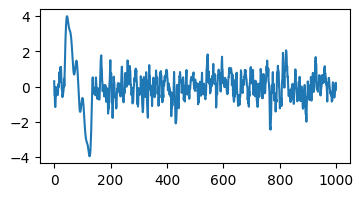

In [3]:
len_base_motif = config.len_base_motif
len_ts = config.len_ts

flat_list = [ts.flatten() for ts in ts_list]

plt.figure(figsize=(4,2))
plt.plot(flat_list[0])
plt.show()

22.00


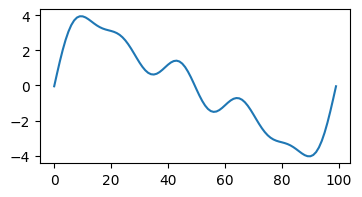

In [4]:
l_min = len_base_motif - 25
l_max = len_base_motif + 25
rho = 0.8 
nb = None

start_time = time.perf_counter()
motifs1 = loconsensus.apply_loconsensus(ts_list, l_min, l_max, rho, nb)
end_time = time.perf_counter() - start_time
print(f'{end_time:.2f}')
plt.figure(figsize=(4,2))
plt.plot(np.concat(ts_list)[motifs1[0][0][0]: motifs1[0][0][1]])
plt.show()

In [5]:
M, _, _ = prom.matching_matrix([m_pos], [motif_set[1] for motif_set in motifs1])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")

[[ 1.  0.  0.  0.  0.  0.  0.  9.]
 [ 9.  3.  2.  2.  2.  2.  2. nan]]

Micro averaged PROM
Precision: 0.1
Recall: 0.1
F1-score: 0.10000000000000002


[(36, 136), (195, 295), (789, 889), (424, 524), (286, 386), (813, 913), (863, 963), (169, 269), (754, 854), (145, 245)]
[(np.int64(36), np.int64(136)), (np.int64(1195), np.int64(1295)), (np.int64(2789), np.int64(2889)), (np.int64(3424), np.int64(3524)), (np.int64(4286), np.int64(4386)), (np.int64(5813), np.int64(5913)), (np.int64(6863), np.int64(6963)), (np.int64(7169), np.int64(7269)), (np.int64(8754), np.int64(8854)), (np.int64(9145), np.int64(9245))]
26.93


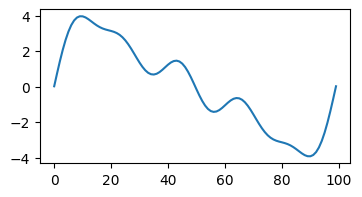

In [6]:
start_time = time.perf_counter()
r, series_idx, subseq_idx = stumpy.ostinato(flat_list, len_base_motif)
cm = flat_list[series_idx][subseq_idx: subseq_idx + len_base_motif]
nn1 = []
for i, ts in enumerate(flat_list):
    ms = np.argmin(stumpy.core.mass(cm, ts))
    nn1.append((ms + i * len_ts, ms + len_base_motif + i * len_ts))
print(m_pos)
print(nn1)
end_time = time.perf_counter() - start_time
print(f'{end_time:.2f}')

plt.figure(figsize=(4,2))
plt.plot(flat_list[series_idx][subseq_idx: subseq_idx+len_base_motif])
plt.show()

In [7]:
M, _, _ = prom.matching_matrix([m_pos], [nn1])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")

[[ 1.  9.]
 [ 9. nan]]

Micro averaged PROM
Precision: 0.1
Recall: 0.1
F1-score: 0.10000000000000002


[(36, 136), (195, 295), (789, 889), (424, 524), (286, 386), (813, 913), (863, 963), (169, 269), (754, 854), (145, 245)]
[(np.int64(36), np.int64(136)), (np.int64(1195), np.int64(1295)), (np.int64(2789), np.int64(2889)), (np.int64(3424), np.int64(3524)), (np.int64(4286), np.int64(4386)), (np.int64(5813), np.int64(5913)), (np.int64(6863), np.int64(6963)), (np.int64(7169), np.int64(7269)), (np.int64(8754), np.int64(8854)), (np.int64(9145), np.int64(9245))]
2.66


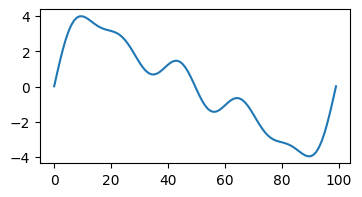

In [8]:
def top1(radii):
    min_dist_per_series = [np.min(radii[i]) for i in range(len(flat_list))]
    min_idx_per_series = [np.argmin(radii[i]) for i in range(len(flat_list))]
    min_idx = np.argmin(min_dist_per_series)
    series_idx = min_idx
    subseq_idx = min_idx_per_series[series_idx]
    return series_idx, subseq_idx

start_time = time.perf_counter()
oa = OstinatoAnytime(flat_list, len_base_motif)
oa.calculate(1.0)
r1 = oa.get_radii()
series_idx, subseq_idx = top1(r1)

cm = flat_list[series_idx][subseq_idx: subseq_idx + len_base_motif]
nn2 = []
for i, ts in enumerate(flat_list):
    ms = np.argmin(stumpy.core.mass(cm, ts))
    nn2.append((ms + i * len_ts, ms + len_base_motif + i * len_ts))
print(m_pos)
print(nn2)
end_time = time.perf_counter() - start_time
print(f'{end_time:.2f}')

plt.figure(figsize=(4,2))
plt.plot(flat_list[series_idx][subseq_idx:subseq_idx+len_base_motif])

In [9]:
M, _, _ = prom.matching_matrix([m_pos], [nn2])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")

[[ 1.  9.]
 [ 9. nan]]

Micro averaged PROM
Precision: 0.1
Recall: 0.1
F1-score: 0.10000000000000002


In [9]:
"""
minsup = 0.25
seglen = 5
alfabet = 5
min_len = 5
max_len = 10
miner = Miner(minsup, seglen, alfabet, min_len=min_len)
start_time = time.perf_counter()
motifs2 = miner.mine(flat_list)
end_time = time.perf_counter() - start_time
print(motifs2)
print(f'{end_time:.2f}')

print(motifs2[0].pattern)
print(motifs2[0].indexes)
print(motifs2[0].average_occurrences)
print(motifs2[0].representative)
print(motifs2[0].best_matches)


if len(motifs2) != 0:
    plt.figure(figsize=(4,2))
    plt.plot(motifs2[0].representative)
    plt.show()
    plt.figure(figsize=(4,2))
    plt.plot(motifs2[1].representative)
    plt.show()
"""

"\nminsup = 0.25\nseglen = 5\nalfabet = 5\nmin_len = 5\nmax_len = 10\nminer = Miner(minsup, seglen, alfabet, min_len=min_len)\nstart_time = time.perf_counter()\nmotifs2 = miner.mine(flat_list)\nend_time = time.perf_counter() - start_time\nprint(motifs2)\nprint(f'{end_time:.2f}')\n\nprint(motifs2[0].pattern)\nprint(motifs2[0].indexes)\nprint(motifs2[0].average_occurrences)\nprint(motifs2[0].representative)\nprint(motifs2[0].best_matches)\n\n\nif len(motifs2) != 0:\n    plt.figure(figsize=(4,2))\n    plt.plot(motifs2[0].representative)\n    plt.show()\n    plt.figure(figsize=(4,2))\n    plt.plot(motifs2[1].representative)\n    plt.show()\n"